In [185]:
#TODO:Correlazione, funzione che prevede i likes dato num di views, ttest

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [187]:
ted = pd.read_csv('data.csv')
ted.head()

,title,author,date,views,likes,link
0,Climate action needs new frontline leadership,Ozawa Bineshi Albert,December 2021,404000,12000,https://ted.com/talks/ozawa_bineshi_albert_cli...
1,The dark history of the overthrow of Hawaii,Sydney Iaukea,February 2022,214000,6400,https://ted.com/talks/sydney_iaukea_the_dark_h...
2,How play can spark new ideas for your business,Martin Reeves,September 2021,412000,12000,https://ted.com/talks/martin_reeves_how_play_c...
3,Why is China appointing judges to combat clima...,James K. Thornton,October 2021,427000,12000,https://ted.com/talks/james_k_thornton_why_is_...
4,Cement's carbon problem — and 2 ways to fix it,Mahendra Singhi,October 2021,2400,72,https://ted.com/talks/mahendra_singhi_cement_s...


In [188]:
ted.shape

(5440, 6)

In [189]:
ted_quantitative = ted[['views','likes']]
ted_qualitative = ted[['title', 'author', 'date', 'link']]

In [190]:
ted_quantitative.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,views,likes
count,5440.00000,5440.00000
mean,2061575.95790,62607.61673
std,3567097.76512,107646.76946
min,532.00000,15.00000
25%,670750.00000,20000.00000
50%,1300000.00000,40500.00000
75%,2100000.00000,65000.00000
max,72000000.00000,2100000.00000


In [191]:
ted_qualitative.describe()

,title,author,date,link
count,5440,5439,5440,5440
unique,5440,4443,200,5440
top,Climate action needs new frontline leadership,Alex Gendler,April 2018,https://ted.com/talks/ozawa_bineshi_albert_cli...
freq,1,45,127,1


In [192]:
ted[ted.isnull().any(axis=1)]

,title,author,date,views,likes,link
3039,Year In Ideas 2015,NaN,December 2015,532,15,https://ted.com/talks/year_in_ideas_2015


In [193]:
ted_quantitative.corr()

,views,likes
views,1.000000,0.999661
likes,0.999661,1.000000


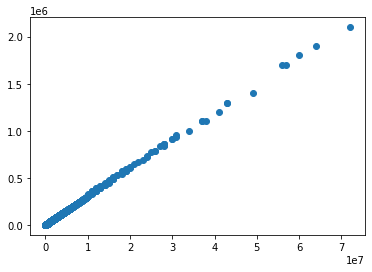

In [194]:
plt.scatter(ted['views'], ted['likes'])

intercept: 241.78538868208125
coefficient: [0.03026663]


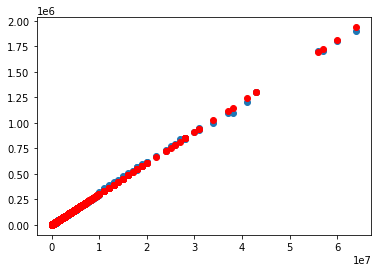

In [197]:
features = ['views']
x = ted[features]
y = ted['likes']
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3)
regressor = LinearRegression()
lin_reg = regressor.fit(X_train, y_train)

print('intercept:', lin_reg.intercept_)
print('coefficient:', lin_reg.coef_)

plt.scatter(X_train, y_train)

y_hat = X_train * lin_reg.coef_ + lin_reg.intercept_

plt.scatter(X_train, y_hat, color='r') #TODO: mettere una linea